In [150]:
import re
import os
import matplotlib.pyplot as plt

import picbreeder_util


In [9]:
import zipfile
import xml.etree.ElementTree as ET


def _xml_to_dict(element):
    node = {}
    if element.attrib:
        node.update({f"@{key}": value for key, value in element.attrib.items()})
    children = list(element)
    if children:
        child_dict = {}
        for child in children:
            child_name = child.tag
            child_dict.setdefault(child_name, []).append(_xml_to_dict(child))
        for key, value in child_dict.items():
            node[key] = value if len(value) > 1 else value[0]
    else:
        if element.text and element.text.strip():
            node["#text"] = element.text.strip()
    return node

def load_zip_xml_as_dict(zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        file_list = zip_ref.namelist()
        assert len(file_list) == 1
        for file_name in file_list:
            with zip_ref.open(file_name) as file:
                file_content = file.read().decode('utf-8')
    element = ET.fromstring(file_content)
    root = _xml_to_dict(element)
    return root

In [186]:
import jax.numpy as jnp
from cppn import activation_fn_map
from color import hsv2rgb

def load_pbcppn(genome):
    ns, ls = [], []
    nodes_ = genome['nodes']['node']
    links_ = genome['links']['link']
    nodes, links = [], []
    for node in nodes_:
        # node = dict(label=node['@label'] if '@label' in node else "", id=int(node['marking']['@id']), activation=node['activation']['#text'][:-3])
        id_ = node['marking']['@branch']+"_"+node['marking']['@id']
        node = dict(label=node['@label'] if '@label' in node else "", id=id_, activation=node['activation']['#text'][:-3])
        nodes.append(node)
    for link in links_:
        # link = dict(id=int(link['marking']['@id']), source=int(link['source']['@id']), target=int(link['target']['@id']), weight=float(link['weight']['#text']))

        source_id = link['source']['@branch']+"_"+link['source']['@id']
        target_id = link['target']['@branch']+"_"+link['target']['@id']
        link = dict(id=int(link['marking']['@id']), source=source_id, target=target_id, weight=float(link['weight']['#text']))
        links.append(link)

    if 'ink' in [node['label'] for node in nodes]: # convert ink output to hsv standard
        node_v = [node for node in nodes if node['label'] == 'ink'][0]
        node_v['label'] = 'brightness'
        nodes.append(dict(label='hue', id=1000000, activation='identity'))
        nodes.append(dict(label='saturation', id=1000001, activation='identity'))
        links.append(dict(id=1000002, source=node_v['id'], target=1000000, weight=0.))
        links.append(dict(id=1000003, source=node_v['id'], target=1000001, weight=0.))

    special_nodes = {}
    special_nodes['x'] = [node['id'] for node in nodes if node['label'] == 'x'][0]
    special_nodes['y'] = [node['id'] for node in nodes if node['label'] == 'y'][0]
    special_nodes['d'] = [node['id'] for node in nodes if node['label'] == 'd'][0]
    special_nodes['bias'] = [node['id'] for node in nodes if node['label'] == 'bias'][0]
    special_nodes['h'] = [node['id'] for node in nodes if node['label'] == 'hue'][0]
    special_nodes['s'] = [node['id'] for node in nodes if node['label'] == 'saturation'][0]
    special_nodes['v'] = [node['id'] for node in nodes if node['label'] == 'brightness'][0]
    # links = [link for link in links if link['weight'] != 0.]
    return dict(nodes=nodes, links=links, special_nodes=special_nodes)

def do_forward_pass(nn, res=64):
    x = y = jnp.linspace(-1., 1., res)
    x, y = jnp.meshgrid(x, y)
    d = jnp.sqrt(x**2 + y**2)*1.4
    b = jnp.ones_like(x)

    node2activation = {n['id']: n['activation'] for n in nn['nodes']}
    node2out_links = {n['id']: [(l['target'], l['weight']) for l in nn['links'] if l['source'] == n['id']] for n in nn['nodes']}
    node2in_links = {n['id']: [(l['source'], l['weight']) for l in nn['links'] if l['target'] == n['id']] for n in nn['nodes']}
    node_x = nn['special_nodes']['x']
    node_y = nn['special_nodes']['y']
    node_d = nn['special_nodes']['d']
    node_b = nn['special_nodes']['bias']
    node_h = nn['special_nodes']['h']
    node_s = nn['special_nodes']['s']
    node_v = nn['special_nodes']['v']

    node2val = {} #{node['id']: np.zeros_like(x) for node in nn['nodes']}
    node2val[node_x], node2val[node_y], node2val[node_d], node2val[node_b] = x, y, d, b

    def get_value_recur(node, path=[]):
        if node in node2val:
            return node2val[node]
        if node in path:
            print(f'CYCLE: {path}')
            return jnp.zeros_like(x)
        val = jnp.zeros_like(x)
        for node_src, weight in node2in_links[node]:
            val = val + weight * get_value_recur(node_src, path=path+[node])
        node2val[node] = activation_fn_map[node2activation[node]](val)
        return node2val[node]

    for node in [node_h, node_s, node_v]: # actual forward pass
        get_value_recur(node, path=[])
    
    h, s, v = node2val[node_h], node2val[node_s], node2val[node_v]
    r, g, b = hsv2rgb((h+1)%1, s.clip(0,1), jnp.abs(v).clip(0, 1))
    rgb = jnp.stack([r, g, b], axis=-1)
    return dict(rgb=rgb, node2val=node2val)

In [ ]:
pb_dir = "/home/akarsh_sakana_ai/spaghetti-data/spaghetti/pbRender/genomeAll/"
pid = "apple_genome"

for file in ["0.zip", "1.zip", "2.zip", "main.zip", "rep.zip"]:
    zip_file_path = f"{pb_dir}/{pid}/{file}"
    root = load_zip_xml_as_dict(zip_file_path)
    print(root)


{'@version': '1.0', 'storage': {'@maximum': '9', '@minimum': '0', '@name': '0', 'generation': [{'@number': '0', '@size': '1', 'genome': {'@age': '50', 'identifier': {'@branch': '576', '@id': '0'}, 'parents': {'@count': '1', 'identifier': {'@branch': '542', '@id': '214'}}, 'nodes': {'@count': '14', 'node': [{'@label': 'bias', '@type': 'in', 'marking': {'@branch': '534', '@id': '0'}, 'activation': {'#text': 'identity(x)'}}, {'@label': 'd', '@type': 'in', 'marking': {'@branch': '534', '@id': '1'}, 'activation': {'#text': 'identity(x)'}}, {'@label': 'x', '@type': 'in', 'marking': {'@branch': '534', '@id': '2'}, 'activation': {'#text': 'identity(x)'}}, {'@label': 'y', '@type': 'in', 'marking': {'@branch': '534', '@id': '3'}, 'activation': {'#text': 'identity(x)'}}, {'@label': 'ink', '@type': 'out', 'marking': {'@branch': '534', '@id': '4'}, 'activation': {'#text': 'gaussian(x)'}}, {'@type': 'hidden', 'marking': {'@branch': '534', '@id': '5'}, 'activation': {'#text': 'gaussian(x)'}}, {'@type

In [170]:
def recursive_parse_all_genomes(root, all_genomes=None):
    if all_genomes is None:
        all_genomes = []
    if isinstance(root, list):
        for r in root:
            recursive_parse_all_genomes(r, all_genomes=all_genomes)
    if isinstance(root, dict) and 'nodes' in root and 'links' in root:
        all_genomes.append(root)
    elif isinstance(root, dict):
        for k, v in root.items():
            recursive_parse_all_genomes(v, all_genomes=all_genomes)
    return all_genomes

def get_genome(pb_dir, pid):
    zip_file_path = f"{pb_dir}/{pid}/rep.zip"
    root = load_zip_xml_as_dict(zip_file_path)
    genome = root['genome']
    return genome

def get_lineage_genomes(pb_dir, pid):
    genomes = []
    lineage = picbreeder_util.get_pid_lineage(pb_dir, pid)
    roots = []
    for pid in lineage:
        files = [f for f in os.listdir(f"{pb_dir}/{pid}") if re.fullmatch(r'\d+\.zip', f)]
        for zip_file_path in files:
            zip_file_path = f"{pb_dir}/{pid}/{zip_file_path}"
            roots.append(load_zip_xml_as_dict(zip_file_path)['storage']['generation'])
    genomes = recursive_parse_all_genomes(roots)
    sorted_genomes = sorted(genomes, key=lambda g: int(g["@age"]))
    return sorted_genomes

In [173]:
genomes = get_lineage_genomes(pb_dir, "576")

In [189]:
pids = [
    4376, 576, 5736, 4034,
    4056, 4041, 3873, 3806,
    5777, 4737, 7501, 8910,
    7513, 4270, 7482, 9473,
    # 1803, 5035,
]
for pid in pids:
    try:
        genomes = get_lineage_genomes(pb_dir, pid)
        genomes = genomes[-400:]
    except:
        print(f"No lineage found for {pid}")
        continue
    print(len(genomes))
    plt.figure(figsize=(20, 25))
    for i, genome in enumerate(genomes):
        nn = load_pbcppn(genome)
        img = do_forward_pass(nn)['rgb']
        plt.subplot(20, 20, i+1)
        plt.imshow(img); plt.title(f"{genome['@age']}"); plt.xticks([]); plt.yticks([])
    plt.tight_layout()
    plt.savefig(f"/home/akarsh_sakana_ai/spaghetti-data/figures/lineages/{pid}.pdf", format="pdf", bbox_inches="tight", dpi=100)
    plt.close()

130
75
353
112
132
128
No lineage found for 3873
No lineage found for 3806
400
52
140
No lineage found for 8910
85
183
137
88


STARTING PID:  5736


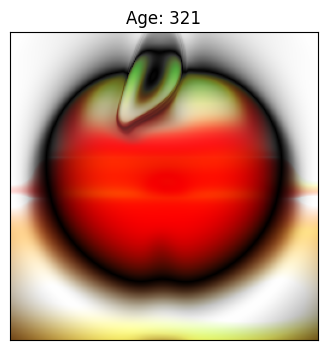

ValueError: num must be an integer with 1 <= num <= 160, not 161

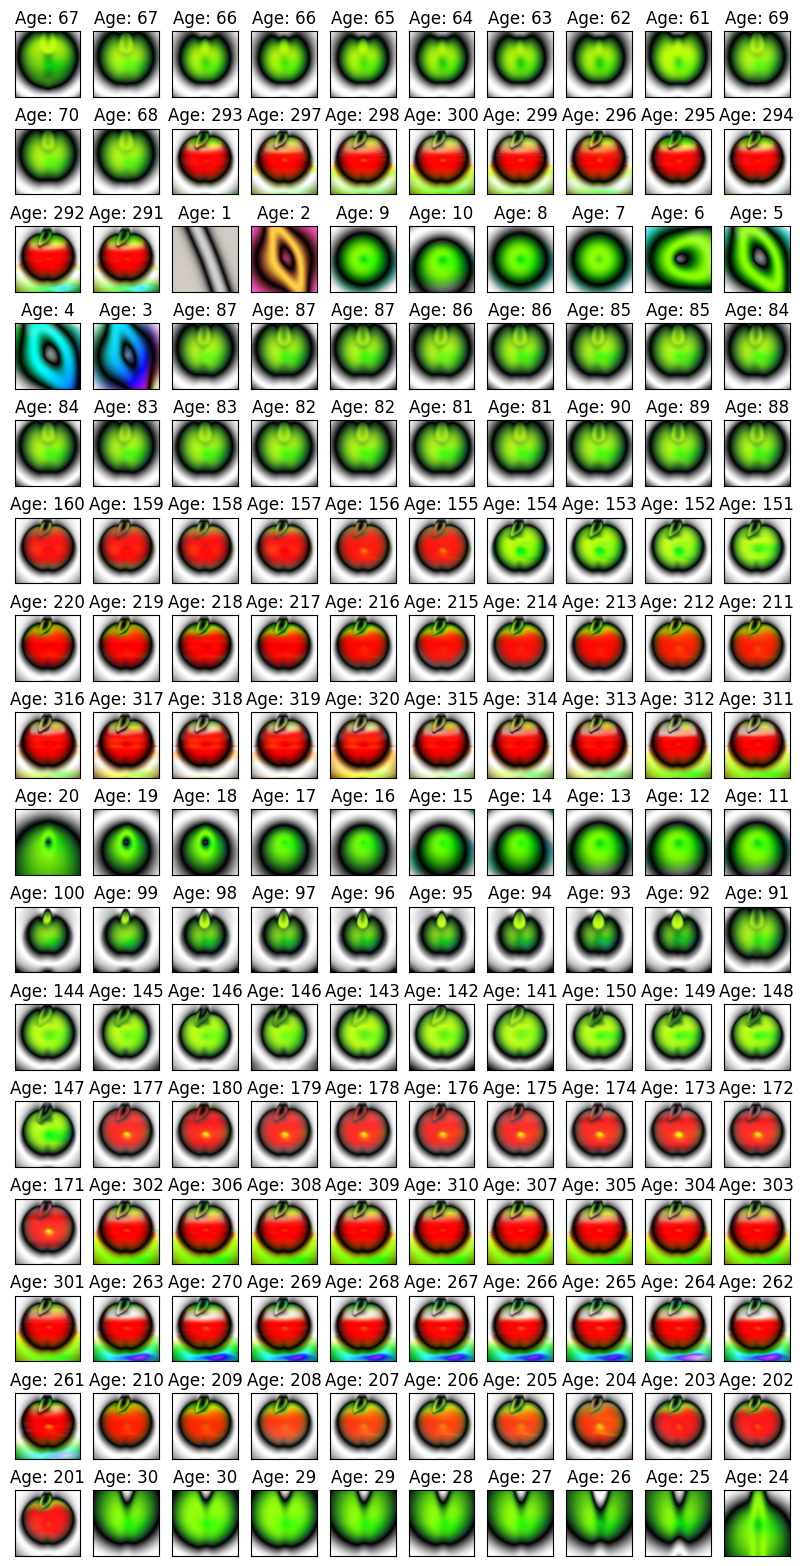

In [153]:
# 5736, 4376, 576
lineage = picbreeder_util.get_pid_lineage(pb_dir, "5736")
for pid in lineage:
    print("STARTING PID: ", pid)
    zip_file_path = f"{pb_dir}/{pid}/rep.zip"
    root = load_zip_xml_as_dict(zip_file_path)
    genome = root['genome']
    nn = load_pbcppn(genome)
    img = do_forward_pass(nn)['rgb']
    plt.figure(figsize=(4, 4))
    plt.imshow(img); plt.title(f"Age: {genome['@age']}"); plt.xticks([]); plt.yticks([])
    plt.show()

    # zip_file_path = f"{pb_dir}/{pid}/0.zip"
    files = [f for f in os.listdir(f"{pb_dir}/{pid}") if re.fullmatch(r'\d+\.zip', f)]
    roots = []
    for zip_file_path in files:
        zip_file_path = f"{pb_dir}/{pid}/{zip_file_path}"
        roots.append(load_zip_xml_as_dict(zip_file_path)['storage']['generation'])
    genomes = get_all_genomes(roots)

    plt.figure(figsize=(10, 20))
    for i, genome in enumerate(genomes):
        nn = load_pbcppn(genome)
        img = do_forward_pass(nn)['rgb']
        plt.subplot(16, 10, i+1)
        plt.imshow(img); plt.title(f"Age: {genome['@age']}"); plt.xticks([]); plt.yticks([])
    plt.show()

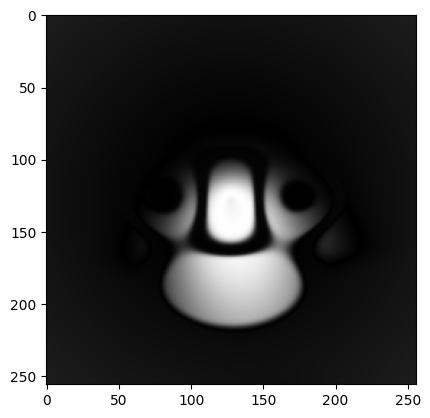

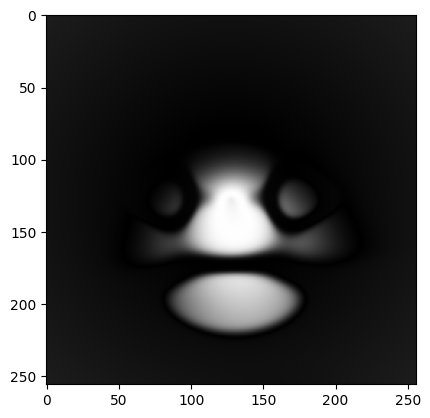

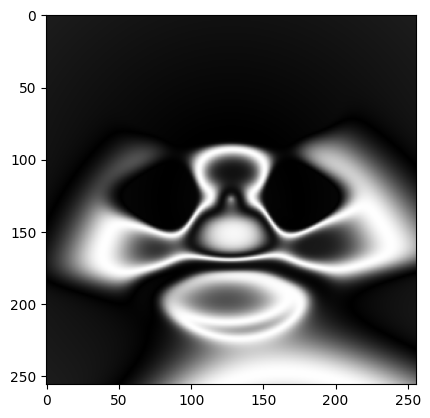

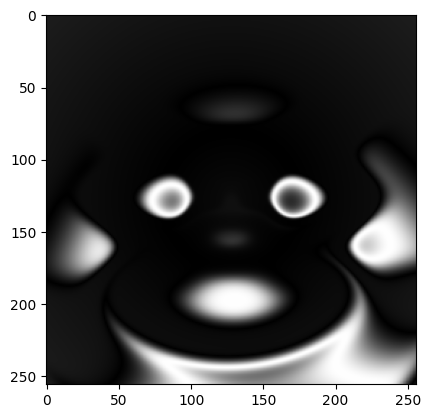

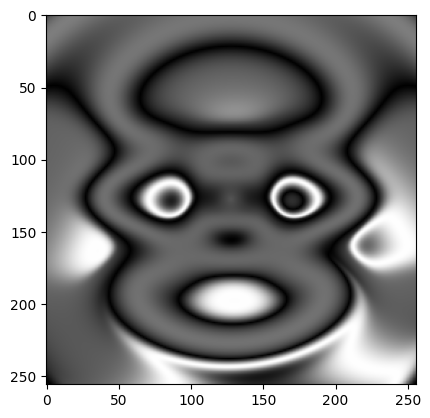

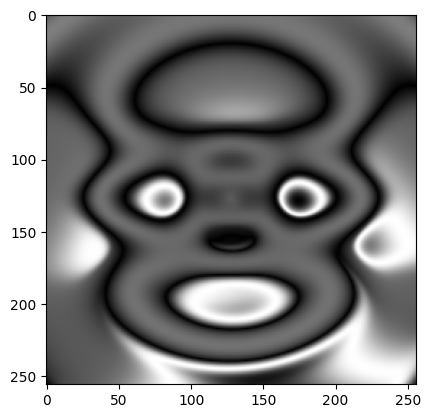

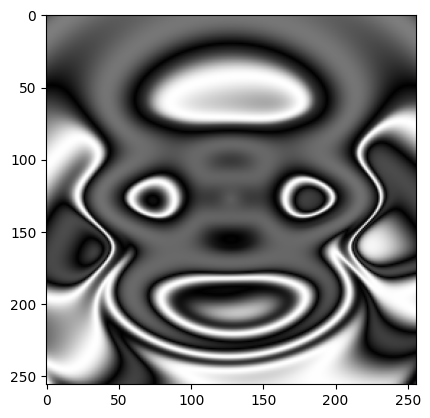

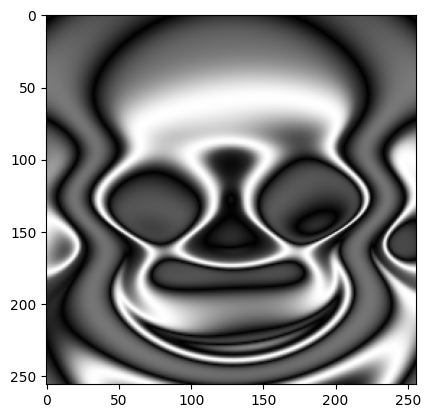

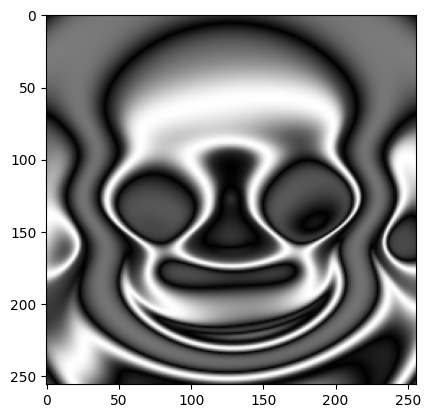

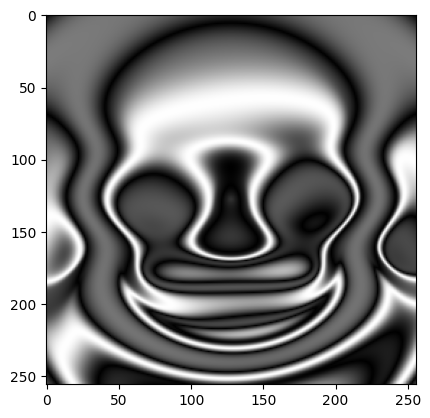

In [47]:
file = "0.zip"
zip_file_path = f"{pb_dir}/{pid}/{file}"
root = load_zip_xml_as_dict(zip_file_path)

for gen in root['storage']['generation']:
    nn = load_pbcppn(gen)
    img = do_forward_pass(nn)['rgb']
    plt.imshow(img)
    plt.show()